In [29]:
%load_ext autoreload
%autoreload 2

import fnmatch
import os
import random
import shutil
import string
import time
from abc import abstractmethod
from collections import defaultdict
from time import sleep

import numpy as np
import monai
from monai.transforms import AddChannel, Compose, Resize, ScaleIntensity, ToTensor
from torch.utils.data import DataLoader, Dataset
from datasets.numpydatasets import Numpy2dDataSet, Numpy3dDataSet
from datasets.cyclegan import CycleGANDataset
import torchvision.transforms as transforms


def get_transforms_2d(target_size=128):
    """Returns a Transform which resizes 2D samples (1xHxW) to a target_size (1 x target_size x target_size)
    and then converts them to a pytorch tensor.
    Args:
        target_size (int, optional): [New spatial dimension of the input data]. Defaults to 128.
    Returns:
        [Transform]
    """

    transforms = Compose([Resize((target_size, target_size)), ToTensor()])
    return transforms


def get_transforms_3d(target_size=128):
    """Returns a Transform which resizes 3D samples (1xZxYxX) to a target_size (1 x target_size x target_size x target_size)
    and then converts them to a pytorch tensor.
    Args:
        target_size (int, optional): [New spatial dimension of the input data]. Defaults to 128.
    Returns:
        [Transform]
    """
    transforms = Compose([Resize((target_size, target_size, target_size)), ToTensor()])
    return transforms


def get_numpy2d_dataset(
    base_dir,
    mode="train",
    batch_size=16,
    n_items=None,
    pin_memory=False,
    num_processes=1,
    drop_last=False,
    target_size=512,
    file_pattern="*data.npy",
    do_reshuffle=True,
    slice_offset=0,
    caching=True,
):
    """Returns a Pytorch data loader which loads a Numpy2dDataSet, i.e. 2D slices from a dir of 3D Numpy arrays.
    Args:
        base_dir ([str]): [Directory in which the npy files are.]
        mode (str, optional): [train or val, loads the first 90% for train and 10% for val]. Defaults to "train".
        batch_size (int, optional): [See pytorch DataLoader]. Defaults to 16.
        n_items ([int], optional): [Number of items in on interation, by default number of files in the loaded set 
                                        but can be smaller (uses subset) or larger (uses file multiple times)]. Defaults to None.
        pin_memory (bool, optional): [See pytorch DataLoader]. Defaults to False.
        num_processes (int, optional): [See pytorch DataLoader]. Defaults to 1.
        drop_last (bool, optional): [See pytorch DataLoader]. Defaults to False.
        target_size (int, optional): [New spatial dimension of to which the input data will be transformed]. Defaults to 128.
        file_pattern (str, optional): [File pattern of files to load from the base_dir]. Defaults to "*data.npy".
        do_reshuffle (bool, optional): [See pytorch DataLoader]. Defaults to True.
        slice_offset (int, optinal): [Offset for the first dimension to skip the first/last n slices]. Defaults to 0.
        caching (bool, optinal): [If True saves the data set list to a file in the base_dir
                                    so files don't have to be indexed again and can be more quickly loaded using the cache file]. Defaults to True.
    Returns:
        [DataLoader]: Pytorch data loader which loads a Numpy2dDataSet
    """

    transforms = get_transforms_2d(target_size=target_size)

    data_set = Numpy2dDataSet(
        base_dir=base_dir,
        mode=mode,
        n_items=n_items,
        file_pattern=file_pattern,
        slice_offset=slice_offset,
        caching=caching,
        transforms=transforms,
    )

    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=do_reshuffle,
        num_workers=num_processes,
        pin_memory=pin_memory,
        drop_last=drop_last,
    )
    return data_loader


def get_numpy3d_dataset(
    base_dir,
    mode="train",
    batch_size=16,
    n_items=None,
    pin_memory=False,
    num_processes=1,
    drop_last=False,
    target_size=128,
    file_pattern="*data.npy",
    do_reshuffle=False,
):
    """Returns a Pytorch data loader which loads a Numpy3dDataSet, i.e. 3D Numpy arrays from a directory.
    Args:
        base_dir ([str]): [Directory in which the npy files are.]
        mode (str, optional): [train or val, loads the first 90% for train and 10% for val]. Defaults to "train".
        batch_size (int, optional): [See pytorch DataLoader]. Defaults to 16.
        n_items ([int], optional): [Number of items in on interation, by default number of files in the loaded set 
                                        but can be smaller (uses subset) or larger (uses file multiple times)]. Defaults to None.
        pin_memory (bool, optional): [See pytorch DataLoader]. Defaults to False.
        num_processes (int, optional): [See pytorch DataLoader]. Defaults to 1.
        drop_last (bool, optional): [See pytorch DataLoader]. Defaults to False.
        target_size (int, optional): [New spatial dimension of to which the input data will be transformed]. Defaults to 128.
        file_pattern (str, optional): [File pattern of files to load from the base_dir]. Defaults to "*data.npy".
        do_reshuffle (bool, optional): [See pytorch DataLoader]. Defaults to True.
    Returns:
        [DataLoader]: Pytorch data loader which loads a Numpy3dDataSet
    """

    transforms = get_transforms_3d(target_size=target_size)

    data_set = Numpy3dDataSet(
        base_dir=base_dir, mode=mode, n_items=n_items, file_pattern=file_pattern, transforms=transforms,
    )

    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        #shuffle=do_reshuffle,
        num_workers=num_processes,
        pin_memory=pin_memory,
        drop_last=drop_last,
    )
    return data_loader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
ds = Numpy3dDataSet("data/trainA",file_pattern="*.jpeg")

In [11]:
print(ds[0])
# npee = np.array(ds[24])
# x = np.moveaxis(npee, 0,-1)
# #x.shape

# from matplotlib import pyplot as plt
# plt.imshow(x, interpolation='nearest')
# plt.show()

data/trainA\crossmoda2021_ldn_2_ceT1_10.jpeg


ValueError: Cannot load file containing pickled data when allow_pickle=False

In [88]:

ds = CycleGANDataset('/dss/dsshome1/lxc09/ra49tad2/data/crossmoda2022_training/',transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.CenterCrop((224,224)),transforms.ToTensor(),transforms.Normalize(0.0085,0.2753)]))

In [89]:
from uvcgan.config import Args
import torch
from uvcgan.models.generator import construct_generator
from uvcgan.torch.funcs       import get_torch_device_smart, seed_everything
from uvcgan.cgan.cyclegan           import CycleGANModel
from uvcgan.cgan import construct_model
device = get_torch_device_smart()
args   = Args.load('uvcgan/outdir/selfie2anime/model_d(cyclegan)_m(cyclegan)_d(basic)_g(vit-unet)_cyclegan_vit-unet-12-none-lsgan-paper-cycle_high-256/')
config = args.config
# model = construct_generator(
#     config.generator, config.image_shape, device
# )

model  = construct_model(
        args.savedir, args.config, is_train = False, device = device
    )
print(model.models.gen_ab.net.layer_input[0].weight)



1 == 48
1 == 48
Parameter containing:
tensor([[[[ 1.3005e-02,  1.3952e-02, -3.1999e-02],
          [ 6.6044e-03,  2.9734e-02,  1.9118e-02],
          [ 1.9742e-03, -1.8376e-02,  2.0817e-02]]],


        [[[-1.3234e-02,  2.6584e-02, -1.8876e-02],
          [-2.3979e-02,  1.3457e-02,  1.5744e-02],
          [ 1.5157e-02,  3.9139e-02,  1.4661e-02]]],


        [[[ 9.0179e-03,  4.2519e-02,  4.5855e-03],
          [ 1.4065e-02, -3.8121e-02, -2.3317e-02],
          [-2.5913e-02,  7.2020e-04,  2.0247e-02]]],


        [[[ 5.4079e-02,  2.7595e-02,  3.4109e-02],
          [ 3.5941e-02,  1.3895e-02, -9.8349e-04],
          [-3.2611e-02,  1.4144e-02,  1.9968e-02]]],


        [[[-3.0982e-02, -6.4890e-03, -1.0135e-03],
          [ 2.3351e-02, -6.7050e-03, -1.7031e-02],
          [ 2.5328e-02, -2.1503e-02,  2.0767e-02]]],


        [[[ 2.1888e-02, -5.7418e-02, -2.2323e-02],
          [-4.9550e-03,  1.0491e-02,  2.7539e-03],
          [-1.2889e-02, -2.1758e-02, -4.6859e-03]]],


        [[[ 4.7958e-

In [90]:
dl = DataLoader(ds, batch_size=1)

In [91]:
ex = next(iter(dl))
img = ex['image']
img.shape


torch.Size([1, 1, 224, 224])

Load checkpoint at epoch 200
torch.Size([1, 1, 224, 224])


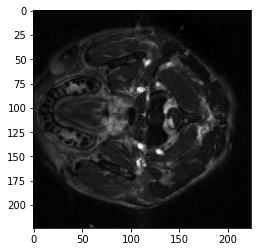

In [98]:
#model = CycleGANModel(**config.model_args)
ckpt = torch.load(os.path.join('uvcgan/outdir/selfie2anime/model_d(cyclegan)_m(cyclegan)_d(basic)_g(vit-unet)_cyclegan_vit-unet-12-none-lsgan-paper-cycle_high-256/opt_gen.pth'),map_location=torch.device('cpu'))
state_dict = ckpt

epoch = -1

if epoch == -1:
    epoch = max(model.find_last_checkpoint_epoch(), 0)

print("Load checkpoint at epoch %s" % epoch)

seed_everything(args.config.seed)
model.load(epoch)

gen_ab = model.models.gen_ab
gen_ab.eval()
plot_it_somehow = gen_ab(img).detach().numpy()


plot_it_somehow = plot_it_somehow.squeeze()



import matplotlib.pyplot as plt

plt.imshow(plot_it_somehow, cmap='gray')
plt.show()



# if torch.cuda.is_available():
#     if torch.cuda.device_count() > 1:
#         model = torch.nn.DataParallel(model)
#     else:
#         new_state_dict = {}
#         for k, v in state_dict.items():
#             k = k.replace("module.", "")
#             new_state_dict[k] = v
#         state_dict = new_state_dict
#     model = model.cuda()
# model.load_state_dict(state_dict, strict=True)

In [31]:
ds[10]['image'].shape , ds[10]['label'].shape

(torch.Size([1, 180, 225]), torch.Size([256, 256, 110]))

In [25]:
dl = DataLoader(ds, batch_size=1)


In [26]:
ex = next(iter(dl))
img = ex['label']
img

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

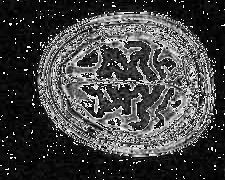

In [6]:
import PIL
PIL.Image.fromarray((img * 255).astype(np.uint8))

In [123]:
mean = 0.0
meansq = 0.0
count = 0
from functools import reduce
for index, data in enumerate(dl):
    #mean= reduce((lambda x, y: x + y), data)
    mean = data.sum()
    #inter = reduce((lambda x, y: x**2 + y), data)
    meansq = meansq + (data**2).sum()
    count += np.prod(data.shape)

In [124]:
total_mean = mean/count
total_var = (meansq/count) - (total_mean**2)
total_std = torch.sqrt(total_var)

In [125]:
total_mean, total_var, total_std

(tensor(0.0081), tensor(0.0758), tensor(0.2753))